In [84]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#### Create a connection to database file

In [85]:
# Create a connection to a new or existing database file
connection = sqlite3.connect("tornado_tracks.db")

print("Connected:", connection)



Connected: <sqlite3.Connection object at 0x00000185939BC6D0>


#### Load tables from CSV files

In [86]:
weather_detail = pd.read_csv("../Datasets/Clean Files/weather_detail_cleaned.csv")
weather_detail.to_sql("weather_detail", connection, if_exists="replace", index=False)


17723

In [87]:
tornado_tracks = pd.read_csv("../Datasets/Clean Files/tornado_tracks_combined_cleaned.csv")
tornado_tracks.to_sql("tornado_tracks", connection, if_exists="replace", index=False)

530

#### Testing to make sure tables loaded

In [88]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", connection)

,name
0,weather_detail
1,tornado_tracks


In [89]:
pd.read_sql("SELECT * FROM tornado_tracks ;", connection)

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,MAGNITUDE_TYPE,SOURCE,...,END_DIRECTION,END_LOCATION,END_TIME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_NARRATIVE,EPISODE_NARRATIVE,Zip
0,558838,OLDHAM CO.,PEWEE VLY,2015-04-02,1400,Thunderstorm Wind,52,,EG,Broadcast Media,...,SW,PEWEE VLY,1425,38.3100,-85.4900,38.3100,-85.4900,Broadcast media reported a large porch roof bl...,A stalled frontal boundary across the area bro...,40056
1,558833,JEFFERSON CO.,LOUISVILLE,2015-04-02,1435,Hail,1.75,,,Trained Spotter,...,ENE,LOUISVILLE,1455,38.2500,-85.7400,38.2500,-85.7400,Golf ball size hail was reported by a trained ...,A stalled frontal boundary across the area bro...,40202
2,558834,JEFFERSON CO.,INDIAN HILLS,2015-04-02,1440,Hail,1.25,,,Public,...,WSW,INDIAN HILLS,1455,38.2700,-85.7000,38.2700,-85.7000,Half dollar size hail was reported by the public.,A stalled frontal boundary across the area bro...,40206
3,558836,JEFFERSON CO.,INDIAN HILLS,2015-04-02,1445,Hail,0.88,,,Public,...,NE,INDIAN HILLS,1455,38.2900,-85.6400,38.2900,-85.6400,The public reported nickel size hail.,A stalled frontal boundary across the area bro...,40222
4,558835,JEFFERSON CO.,ST MATTHEWS,2015-04-02,1445,Hail,1.75,,,Amateur Radio,...,NW,ST MATTHEWS,1455,38.2600,-85.6400,38.2600,-85.6400,Golf ball size hail was reported by an amateur...,A stalled frontal boundary across the area bro...,40207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1267354,BULLITT CO.,MT WASHINGTON,2025-05-16,2116,Thunderstorm Wind,50,,EG,911 Call Center,...,E,MT WASHINGTON,2116,38.0491,-85.5431,38.0491,-85.5431,A tree was blown down across the 200 block of ...,A strong storm system moved across the central...,40047
526,1267365,BULLITT CO.,MT WASHINGTON,2025-05-16,2116,Thunderstorm Wind,63,,MG,Public,...,E,MT WASHINGTON,2116,38.0500,-85.5400,38.0500,-85.5400,A 73 mph wind gust was measured from both a ha...,A strong storm system moved across the central...,40047
527,1267362,BULLITT CO.,MT WASHINGTON,2025-05-16,2117,Thunderstorm Wind,55,,EG,911 Call Center,...,E,MT WASHINGTON,2117,38.0506,-85.5183,38.0506,-85.5183,A tree was blown down across Hubbard Lane.,A strong storm system moved across the central...,40047
528,1267380,BULLITT CO.,MT WASHINGTON,2025-05-16,2117,Hail,0.75,,,Public,...,NE,MT WASHINGTON,2117,38.0600,-85.5400,38.0600,-85.5400,None,A strong storm system moved across the central...,40047


#### Joining both tables with an inner join.  28 row output

In [90]:

Join = """
SELECT *
FROM tornado_tracks t
inner join weather_detail w
On t.Zip = w.Zip 
AND t.DATE = w.DATE

"""

Join = pd.read_sql(Join, connection)
Join

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,MAGNITUDE_TYPE,SOURCE,...,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,Zip
0,563860,JEFFERSON CO.,(LOU)BOWMAN FLD LOUI,2015-04-08,1752,Hail,0.75,,,Public,...,0.65,0.0,0.0,80.0,56.0,220.0,220.0,15.0,19.9,40041
1,571624,JEFFERSON CO.,OKOLONA,2015-06-17,1646,Thunderstorm Wind,52,,EG,Broadcast Media,...,1.27,0.0,0.0,87.0,69.0,0.0,0.0,0.0,0.0,40229
2,575855,BULLITT CO.,BROOKS,2015-06-18,1554,Thunderstorm Wind,52,,EG,Department of Highways,...,0.96,0.0,0.0,89.0,69.0,0.0,0.0,0.0,0.0,40229
3,576561,JEFFERSON CO.,(SDF)STANIFORD FLD L,2015-06-26,1636,Thunderstorm Wind,50,,MG,ASOS,...,1.06,0.0,0.0,88.0,69.0,200.0,200.0,40.9,57.9,40209
4,583615,JEFFERSON CO.,(LOU)BOWMAN FLD LOUI,2015-07-17,2129,Thunderstorm Wind,52,,EG,Broadcast Media,...,0.77,0.0,0.0,91.0,69.0,360.0,350.0,33.1,47.0,40041
5,622819,JEFFERSON CO.,LOUISVILLE,2016-03-31,1528,Thunderstorm Wind,52,,EG,Public,...,0.40,0.0,0.0,74.0,45.0,0.0,0.0,0.0,0.0,40212
6,757643,JEFFERSON CO.,(LOU)BOWMAN FLD LOUI,2018-05-31,1335,Thunderstorm Wind,56,,MG,Other Federal Agency,...,0.25,0.0,0.0,86.0,69.0,260.0,260.0,35.1,62.0,40041
7,764069,JEFFERSON CO.,LOUISVILLE,2018-07-20,1350,Hail,1.75,,,Public,...,2.35,0.0,0.0,91.0,69.0,280.0,150.0,29.1,44.1,40209
8,764264,JEFFERSON CO.,(LOU)BOWMAN FLD LOUI,2018-07-20,2040,Thunderstorm Wind,52,,MG,ASOS,...,1.71,0.0,0.0,88.0,67.0,190.0,330.0,30.0,59.9,40041
9,764113,JEFFERSON CO.,CORAL RIDGE,2018-07-20,2041,Hail,1,,,Public,...,3.29,0.0,0.0,87.0,64.0,0.0,0.0,0.0,0.0,40229


#### Count of Event type

In [91]:
event_type_count = """
SELECT event_type, COUNT(event_id) AS event_type
FROM tornado_tracks
GROUP BY event_type
ORDER BY event_type DESC
"""
event_type_count = pd.read_sql(event_type_count, connection)
event_type_count

,EVENT_TYPE,event_type
0,Thunderstorm Wind,404
1,Hail,101
2,Tornado,16
3,Heavy Rain,5
4,Lightning,4


### Event Stats function to pull by event type, count, and months

In [92]:
## this function was created using help from Co Pilot

def get_event_stats(connection, event_type="Tornado", months=['06','07','08']):
    """
    Returns yearly counts of events and average temperature for a given event type and months.
    
    Parameters:
        connection : sqlite3.Connection
            Active database connection
        event_type : str
            Event type to filter (e.g., 'Tornado', 'Hail', 'Wind')
        months : list of str
            Months to filter (e.g., ['06','07','08'] for summer)
    
    Returns:
        DataFrame with columns: year, event_count, avg_temp
    """
    
    # Convert months list to SQL-friendly string
    month_filter = ",".join([f"'{m}'" for m in months])
    
    event_stats = f"""
    WITH tornado AS (
        SELECT strftime('%Y', date) AS year,
               COUNT(DISTINCT event_id) AS event_count
        FROM tornado_tracks
        WHERE strftime('%m', date) IN ({month_filter})
          AND LOWER(TRIM(event_type)) = LOWER(TRIM('{event_type}'))
        GROUP BY year
    ),
    weather AS (
        SELECT strftime('%Y', date) AS year,
               AVG(tmax) AS avg_temp
        FROM weather_detail
        WHERE strftime('%m', date) IN ({month_filter})
        GROUP BY year
    )
    SELECT t.year, t.event_count, w.avg_temp
    FROM tornado t
    LEFT JOIN weather w ON t.year = w.year
    ORDER BY t.year;
    """
    
    return pd.read_sql(event_stats, connection)



#### Summer Tornados by count and average temperature

In [93]:
summer_tornados = get_event_stats(connection, event_type= "Tornado", months=['03','04','05','06','07'])
summer_tornados

,year,event_count,avg_temp
0,2015,1,75.458498
1,2017,1,76.912418
2,2018,2,75.328063
3,2019,1,74.748281
4,2022,1,76.630719
5,2023,4,74.568627
6,2024,4,77.360065
7,2025,2,76.919804


### Visuals

<p style="margin-left:20px; font-size:22px;">
  Summer Tornado Count vs Average Temperature
</p>

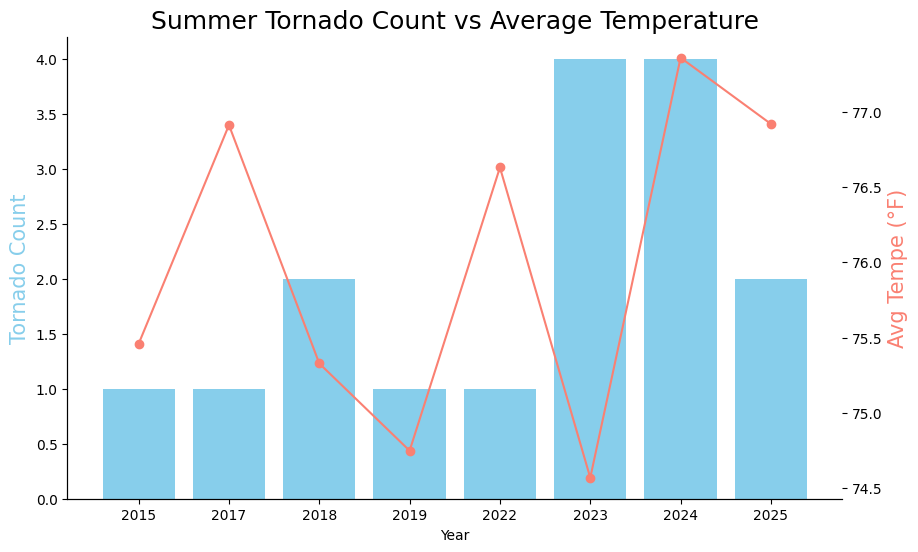

In [94]:
fig, ax1 = plt.subplots(figsize=(10,6))

years = summer_tornados["year"]
tornado_counts = summer_tornados["event_count"]
avg_temps = summer_tornados["avg_temp"]

x = np.arange(len(years))  # positions for bars
width = 0.35               # bar width

# Tornado counts as bars
ax1.bar(years, tornado_counts, color="skyblue", label="Tornado Count")
ax1.set_xlabel("Year")
ax1.set_ylabel("Tornado Count", color="skyblue", fontsize=15)

# Temperature on secondary axis
ax2 = ax1.twinx()
ax2.plot(years, avg_temps, color="salmon", marker="o", label="Avg Temp")
ax2.set_ylabel("Avg Tempe (°F)", color="salmon", fontsize=15)

sns.despine(top=True, right=True)

plt.title("Summer Tornado Count vs Average Temperature", fontsize=18)
plt.savefig("../Visuals/Summer Tornado Count vs Average Temperature.png", dpi=300, bbox_inches="tight")
plt.show()




#### Based on the graph above, the temperature does not appear to have any impact on the number of tornados.  Furthermore, it doesn't appear that the number of tornados are steadily increasing.  

<p style="margin-left:20px; font-size:22px;">
  Average Monthly Temperatures
</p>

In [95]:
temp = """
SELECT strftime('%Y', date) AS year, awnd, prcp, tmax
FROM weather_detail
GROUP BY year
ORDER BY year
"""
temp = pd.read_sql(temp , connection)
temp

,year,AWND,PRCP,TMAX
0,2015,8.05,0.00,40.0
1,2016,8.50,0.00,42.0
2,2017,3.36,0.02,49.0
3,2018,6.71,0.00,17.0
4,2019,4.47,0.00,54.0
5,2020,8.05,0.00,50.0
6,2021,9.62,1.04,65.0
7,2022,4.92,1.91,64.0
8,2023,2.91,0.00,56.0
9,2024,6.04,0.00,38.0


In [96]:
avg_temps='''
SELECT strftime('%Y', date) AS year,
       AVG(CASE WHEN strftime('%m', date) = '01' THEN tmax END) AS Jan,
       AVG(CASE WHEN strftime('%m', date) = '02' THEN tmax END) AS Feb,
       AVG(CASE WHEN strftime('%m', date) = '03' THEN tmax END) AS Mar,
       AVG(CASE WHEN strftime('%m', date) = '04' THEN tmax END) AS Apr,
       AVG(CASE WHEN strftime('%m', date) = '05' THEN tmax END) AS May,
       AVG(CASE WHEN strftime('%m', date) = '06' THEN tmax END) AS Jun,
       AVG(CASE WHEN strftime('%m', date) = '07' THEN tmax END) AS Jul,
       AVG(CASE WHEN strftime('%m', date) = '08' THEN tmax END) AS Aug,
       AVG(CASE WHEN strftime('%m', date) = '09' THEN tmax END) AS Sep,
       AVG(CASE WHEN strftime('%m', date) = '10' THEN tmax END) AS Oct,
       AVG(CASE WHEN strftime('%m', date) = '11' THEN tmax END) AS Nov,
       AVG(CASE WHEN strftime('%m', date) = '12' THEN tmax END) AS Dec
FROM weather_detail
GROUP BY year 
ORDER BY year DESC;
'''

avg_temps = pd.read_sql(avg_temps, connection)
avg_temps




,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2025,37.451613,47.750000,63.709677,70.116667,73.894309,86.250000,90.685484,85.695652,83.577778,86.000000,NaN,NaN
1,2024,40.201613,57.379310,62.317073,70.608333,79.532258,86.541667,87.758065,88.645161,83.025000,74.373984,60.512605,48.637097
2,2023,50.088710,56.053571,57.838710,69.525000,75.693548,82.175000,87.693548,85.894309,83.100840,70.512195,59.900000,52.201613
3,2022,40.693548,49.008929,61.669355,65.291667,79.306452,87.391667,89.475806,86.991935,81.150000,69.959350,57.883333,46.000000
4,2021,42.420000,39.946970,63.447368,67.740000,75.280000,85.566667,87.217742,88.790323,81.916667,72.862903,55.783333,59.088710
5,2020,48.738562,48.347222,61.784173,65.319728,73.771812,85.506757,90.000000,85.297297,79.965517,69.133333,62.384615,47.328671
6,2019,42.394737,51.463235,54.091503,70.577181,78.967320,82.812950,89.902256,88.157895,90.067114,72.748344,51.832168,51.973856
7,2018,40.520270,53.678832,54.025974,63.328859,84.409091,86.843537,88.083871,86.477124,82.155405,70.503268,50.986486,49.869281
8,2017,48.966887,58.451852,60.058065,74.453333,77.058065,84.793333,88.374194,84.980645,80.386667,70.535484,58.006803,45.203947
9,2016,42.853333,48.937063,62.728477,70.033333,73.915584,86.966216,88.109677,88.155844,84.693333,76.205298,63.643836,45.589404


In [97]:
avg_temps = avg_temps.fillna(0)
avg_temps_round = avg_temps.round(0).astype(int)

avg_temps_round



,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2025,37,48,64,70,74,86,91,86,84,86,0,0
1,2024,40,57,62,71,80,87,88,89,83,74,61,49
2,2023,50,56,58,70,76,82,88,86,83,71,60,52
3,2022,41,49,62,65,79,87,89,87,81,70,58,46
4,2021,42,40,63,68,75,86,87,89,82,73,56,59
5,2020,49,48,62,65,74,86,90,85,80,69,62,47
6,2019,42,51,54,71,79,83,90,88,90,73,52,52
7,2018,41,54,54,63,84,87,88,86,82,71,51,50
8,2017,49,58,60,74,77,85,88,85,80,71,58,45
9,2016,43,49,63,70,74,87,88,88,85,76,64,46


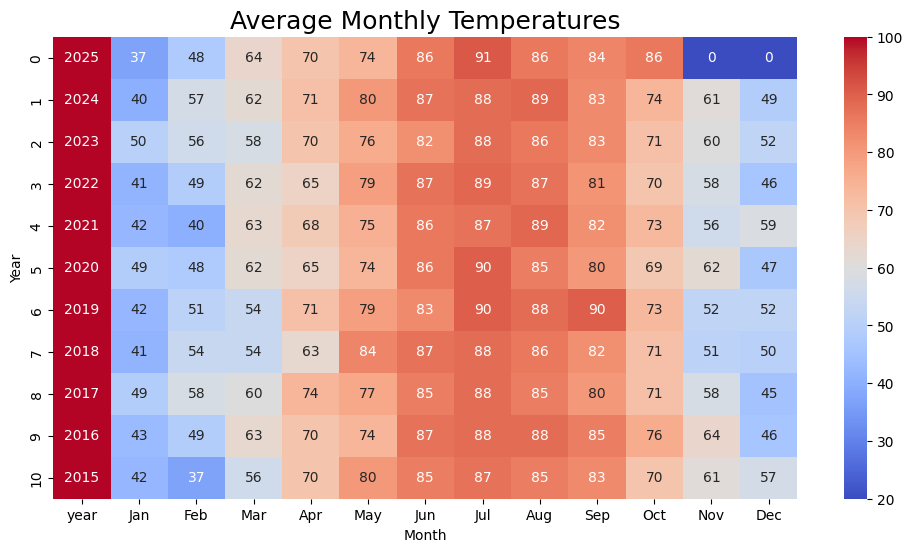

In [98]:
plt.figure(figsize=(12,6))
sns.heatmap(avg_temps_round, cmap="coolwarm", annot=True, fmt=".0f",
            vmin=20, vmax=100)   # adjust to climate range

plt.title("Average Monthly Temperatures", fontsize=18)
plt.xlabel("Month")
plt.ylabel("Year")
plt.savefig("../Visuals/Average Monthly Temperatures.png", dpi=300, bbox_inches="tight")
plt.show()


#### Based on the heatmap, the summer temperatures are creeping upward slightly.  
- Early years (2015–2017):
~85–88°F
- Middle years (2018–2021):
~86–90°F
- Recent years (2022–2025):
~87–91°F

The shift is small but noticeable: summer highs are creeping upward by a few degrees over the decade.
This suggests a gradual warming trend in peak summer temperatures.


<p style="margin-left:20px; font-size:22px;">
  Average Magnitude by year 
</p> 

In [99]:
avg_magnitude= """
SELECT 
    substr(date,1,4) as year,
    event_type, 
    avg(magnitude) as avg_magnitude  
FROM tornado_tracks
where event_type = "Thunderstorm Wind"
    and substr(date,6,2) between '05' and '08'
group by year, event_type
order by year;

"""

avg_magnitude = pd.read_sql(avg_magnitude, connection)
avg_magnitude

,year,EVENT_TYPE,avg_magnitude
0,2015,Thunderstorm Wind,52.000000
1,2016,Thunderstorm Wind,52.314286
2,2017,Thunderstorm Wind,53.000000
3,2018,Thunderstorm Wind,52.680000
4,2019,Thunderstorm Wind,52.583333
5,2020,Thunderstorm Wind,52.125000
6,2021,Thunderstorm Wind,51.666667
7,2022,Thunderstorm Wind,52.333333
8,2023,Thunderstorm Wind,53.161290
9,2024,Thunderstorm Wind,55.758621


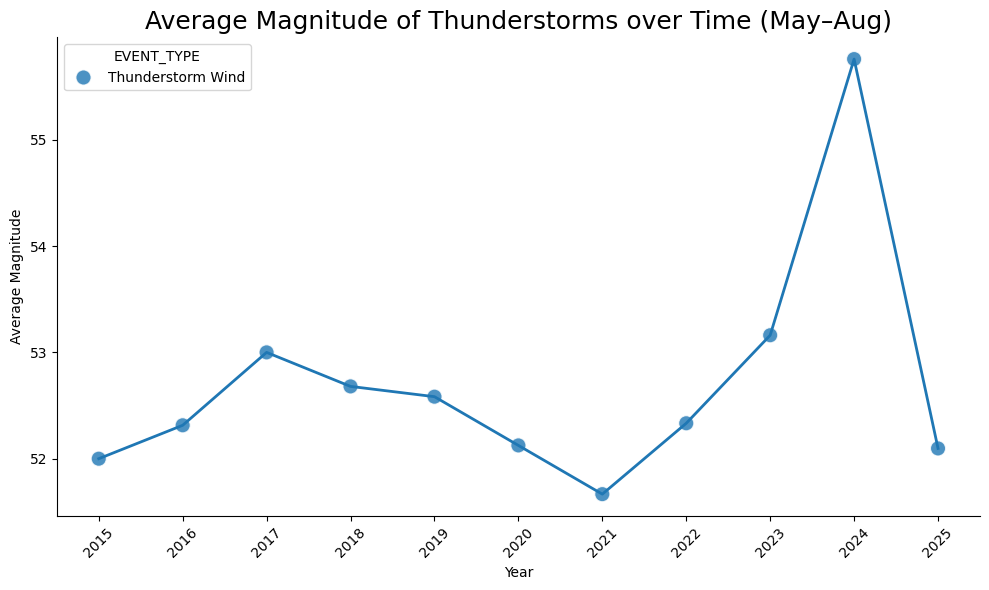

In [100]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=avg_magnitude,
    x="year",
    y="avg_magnitude",
    hue="EVENT_TYPE",
    s=120,          # size of points
    alpha=0.8       # transparency
)

sns.lineplot(
    data=avg_magnitude,
    x="year",
    y="avg_magnitude",
    hue="EVENT_TYPE",
    estimator=None,
    lw=2,
    legend=False
)

sns.despine(top=True, right=True)

plt.title("Average Magnitude of Thunderstorms over Time (May–Aug)", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../Visuals/Average Magnitude of Thunderstorms over Time.png", dpi=300, bbox_inches="tight")
plt.show()

#### It looks like the magnitude (severity) of thunderstorms were on the increase from 2022 on until 2025 with a steep decline.  2025 could be an anomoly and the severity of thunderstorms are on the rise.  I would like to do further research on magnitudes of thunderstorms by taking it back prior to 2015. 

#### Close Connection

In [101]:
# Always close your connection when you're done
connection.close()